In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
import time

In [2]:
#os.chdir(r"D:\Ftest\2025站点数据\处理后数据")

In [3]:
#os.chdir(r"D:\Ftest\2025站点数据\除去异常值后的分类数据\森林")

In [4]:
#os.chdir(r"D:\Ftest\2025站点数据\8站点日数据处理后数据")

In [5]:
os.chdir(r"D:\Ftest\2025站点数据\8日站点数据多生态系统\草地")

In [6]:
!dir

 驱动器 D 中的卷是 DATA1
 卷的序列号是 D8D3-9426

 D:\Ftest\2025站点数据\8日站点数据多生态系统\草地 的目录

2025/02/27  16:16    <DIR>          .
2025/02/24  19:04    <DIR>          ..
2025/02/23  23:26           227,950 当雄merged_RS.csv
               1 个文件        227,950 字节
               2 个目录 103,738,601,472 可用字节


In [7]:
dataset = []
time_window =8
input_var = 10
for site in os.listdir("."):
    #site_data = pd.read_csv("./"+site+"/dataset.csv").to_numpy()
    #site_data = pd.read_excel(site).to_numpy()
    #site_data = pd.read_excel(site)
    site_data = pd.read_csv(site)
    print(site)
    #site_data=site_data.drop(['Slope','Lai','DEM'],axis=1).values
    #site_data=site_data.drop(['Slope','Lai','DEM'],axis=1).values
    site_data=site_data.drop(['VP'],axis=1).values
    #site_data = site_data.to_numpy()
    # 由于 site_data 现在是 NumPy 数组，不能再使用 head() 方法
    # 可以打印数组的前几行查看
   # print(site_data[:5])
    # 每个站点单独归一化,不对NEE做归一化
    #scaler = StandardScaler()
    #site_data[:,2:] = scaler.fit_transform(site_data[:,2:])
    for i in range(len(site_data) - time_window):
        window_data = site_data[i:i+time_window]
        dataset.append(window_data)

当雄merged_RS.csv


In [8]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(42)

In [9]:
# 将 dataset 从列表转换为 NumPy 数组
dataset = np.array(dataset)
#print(dataset[:5])
#print(dataset[:,:,2:])
# 确认 dataset 已转换为 NumPy 数组
print(f"dataset 的类型: {type(dataset)}")
# 所有数据归一化
scaler = StandardScaler()
# 注意：由于 dataset 是三维数组，需要先将后两维展平进行归一化，再恢复形状
original_shape = dataset[:, :, 2:].shape
flattened = dataset[:, :, 2:].reshape(-1, original_shape[-1])
normalized_flattened = scaler.fit_transform(flattened)
dataset[:, :, 2:] = normalized_flattened.reshape(original_shape)
print(dataset[:,:,1])

dataset 的类型: <class 'numpy.ndarray'>
[[0.06695419 0.06774697 0.07089704 ... 0.05907437 0.08371438 0.07838682]
 [0.06774697 0.07089704 0.07007895 ... 0.08371438 0.07838682 0.07200149]
 [0.07089704 0.07007895 0.06226719 ... 0.07838682 0.07200149 0.08153948]
 ...
 [0.24379094 0.20256778 0.2407752  ... 0.24227636 0.21283784 0.24257137]
 [0.20256778 0.2407752  0.21754741 ... 0.21283784 0.24257137 0.29018226]
 [0.2407752  0.21754741 0.22558715 ... 0.24257137 0.29018226 0.17384412]]


In [10]:
dataset = dataset[:,:,1:]#丢弃date列

In [11]:

dataset = dataset[np.random.permutation(dataset.shape[0])]
train_dataset = dataset[:int(dataset.shape[0]*0.8),:,:].astype(np.float32)
test_dataset = dataset[int(dataset.shape[0]*0.8):,:,:].astype(np.float32)
X = train_dataset[:,:,1:]
Y = train_dataset[:,time_window-1,0]


In [12]:
device = torch.device("cuda:0")
X = torch.from_numpy(X).to(device=device, dtype=torch.float32)
Y = torch.from_numpy(Y).to(device=device, dtype=torch.float32)
train_set = TensorDataset(X, Y.view(-1, 1))
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)

In [13]:
# 定义系列显著性模块
class SeriesSaliencyModule(nn.Module):
    def __init__(self, input_size, seq_len,sigma1=0.1 ):
        super().__init__()
        # 正确应用Xavier初始化
        self.mask = nn.Parameter(torch.ones(seq_len, input_size))  # 可学习掩码
        #nn.init.xavier_uniform_(self.mask)  # 正确初始化
        self.sigma1 = sigma1  # 噪声标准差
       
    def forward(self, x):
        e = torch.ones_like(self.mask)
        x_hat = x + torch.randn_like(x) * self.sigma1
        return self.mask * x_hat + (e - self.mask) * x
#版本2的显著性模块
#lass SeriesSaliencyModule(nn.Module):
#   def __init__(self, input_size, seq_len):
#       super().__init__()
#       # 可学习的掩码矩阵 [D, T]
#       self.mask = nn.Parameter(torch.rand(seq_len, input_size))
#       # 高斯噪声生成器
#       self.noise = torch.distributions.Normal(0, 0.1)
#       
#   def forward(self, x, x_hat=None):
#       # 生成扰动后的参考序列 (Eq.2)
#       if x_hat is None:
#           x_hat = x + self.noise.sample(x.shape).to(x.device)
#       # 掩码混合 (Eq.3)
#       mask_sigmoid = torch.sigmoid(self.mask)  # 约束到[0,1]
#       x_mixed = mask_sigmoid * x_hat + (1 - mask_sigmoid) * x
#       return x_mixed
# 新增系列显著性模块
#class SeriesSaliencyModule(nn.Module):
#    def __init__(self, input_size, seq_len, sigma1=0.1, sigma2=0.5):
#        super().__init__()
#        self.mask = nn.Parameter(torch.ones(seq_len, input_size))  # 可学习掩码
#        self.sigma1 = sigma1  # 噪声标准差
#        self.sigma2 = sigma2  # 模糊参数
#        
#    def forward(self, x, training=True):
#        """
#        x shape: (batch_size, seq_len, input_size)
#        """
#        if training:
#            # 生成两种扰动版本
#            x_noise = x + torch.randn_like(x) * self.sigma1
#            x_blur = self.gaussian_blur(x, kernel_size=3, sigma=self.sigma2)
#            
#            # 混合原始和扰动数据
#            mixed_x = self.mask * x_noise + (1 - self.mask) * x_blur
#            return mixed_x
#        else:
#            # 解释阶段直接返回掩码
#            return self.mask.data
#
#    def gaussian_blur(self, x, kernel_size=3, sigma=0.5):
#        # 简化版高斯模糊实现
#        kernel = self._gaussian_kernel(kernel_size, sigma).to(x.device)
#        kernel = kernel.view(1, 1, kernel_size).repeat(x.shape[2], 1, 1)
#        return torch.nn.functional.conv1d(
#            x.permute(0,2,1), 
#            kernel, 
#            padding=kernel_size//2,
#            groups=x.shape[2]
#        ).permute(0,2,1)
#
#    def _gaussian_kernel(self, size, sigma):
#        coords = torch.arange(size).float() - size//2
#        g = torch.exp(-(coords**2) / (2 * sigma**2))
#        return g / g.sum()
# 定义CNN模型，加入系列显著性模块
class CNNRegressor(nn.Module):
    def __init__(self, input_size, seq_len=time_window, kernel_size=3, stride=1, padding=1):
        super().__init__()
        #self.ar_order  = ar_order  # 保存为类属性
        self.saliency_module = SeriesSaliencyModule(input_size, seq_len)
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=kernel_size,
                               stride=stride, padding=padding)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=kernel_size,
                               stride=stride, padding=padding)
        self.relu2 = nn.ReLU()
        self.flattened_size = self._calculate_flattened_size(seq_len)
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        # AR模块 (Eq.4)
        #self.ar = nn.Linear(ar_order, 1)
    
        
    def forward(self, x):
        
        x = self.saliency_module(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
      
    
        return x

    def _calculate_flattened_size(self, seq_len):
        x = torch.randn(1, self.conv1.in_channels, seq_len)
        x = self.conv1(x)
        x = self.conv2(x)
        return x.view(1, -1).size(1)

# 生成参考系列图像（简单加噪示例）
# 修改参考序列生成函数
#def generate_reference_x(x):
#    noise = torch.randn_like(x) * 0.1
#    return x + noise

In [14]:

#epochs =3000
epochs =1000
learning_rate = 1e-4
net = CNNRegressor(input_size=input_var).to(device=device)
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate, weight_decay=1e-4)
# 新增正则化参数
lambda1 = 0.1  # 掩码L2正则
lambda2 = 0.01 # 正交正则
#optimizer = torch.optim.AdamW([
#    {'params': net.conv1.parameters(), 'lr': 1e-4},
#    {'params': net.conv2.parameters(), 'lr': 1e-4},
#    {'params': net.saliency_module.parameters(), 'lr': 1e-3}  # 显著性模块更高学习率
#], weight_decay=1e-4)
torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000, eta_min=0)
Loss = nn.MSELoss()
#Loss=custom_loss(pred_y, train_y, net.saliency_module.mask)
MinTrainLoss = 1e10
train_loss = []

epoch:[    0/ 1000] time:0.37s current_loss:1.71869
epoch:[   10/ 1000] time:0.42s current_loss:1.67117
epoch:[   20/ 1000] time:0.41s current_loss:1.63897
epoch:[   30/ 1000] time:0.39s current_loss:1.60791
epoch:[   40/ 1000] time:0.46s current_loss:1.57724
epoch:[   50/ 1000] time:0.39s current_loss:1.54772
epoch:[   60/ 1000] time:0.38s current_loss:1.51818
epoch:[   70/ 1000] time:0.37s current_loss:1.48946
epoch:[   80/ 1000] time:0.40s current_loss:1.46117
epoch:[   90/ 1000] time:0.39s current_loss:1.43343
epoch:[  100/ 1000] time:0.39s current_loss:1.40603
epoch:[  110/ 1000] time:0.43s current_loss:1.37873
epoch:[  120/ 1000] time:0.38s current_loss:1.35207
epoch:[  130/ 1000] time:0.41s current_loss:1.32572
epoch:[  140/ 1000] time:0.44s current_loss:1.29952
epoch:[  150/ 1000] time:0.42s current_loss:1.27368
epoch:[  160/ 1000] time:0.49s current_loss:1.24823
epoch:[  170/ 1000] time:0.43s current_loss:1.22293
epoch:[  180/ 1000] time:0.50s current_loss:1.19802
epoch:[  190

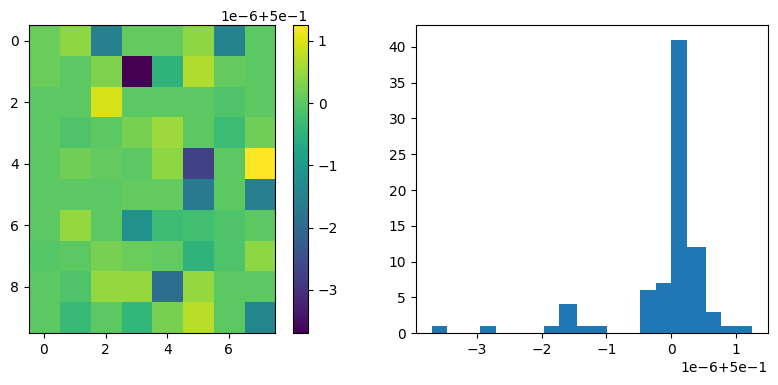

saliency_module.mask grad mean: 0.0013, std: 0.0112
conv1.weight grad mean: -0.0001, std: 0.0003
conv1.bias grad mean: 0.0000, std: 0.0003
conv2.weight grad mean: -0.0000, std: 0.0003
conv2.bias grad mean: -0.0000, std: 0.0006
fc1.weight grad mean: -0.0000, std: 0.0000
fc1.bias grad mean: -0.0000, std: 0.0002
fc2.weight grad mean: -0.0003, std: 0.0004
fc2.bias grad mean: -0.0022, std: nan


C:\Users\Shelby\AppData\Local\Temp\ipykernel_25680\1481535267.py:62: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1831.)
  print(f"{name} grad mean: {param.grad.mean().item():.4f}, std: {param.grad.std().item():.4f}")


In [15]:
start = time.time()
start0 = time.time()
net.train()
for epoch in range(epochs):
    train_epoch_loss = 0
    
    for i, (train_x, train_y) in enumerate(train_loader):
        #train_x_hat = generate_reference_x(train_x)
        #train_x_hat = generate_reference_x(train_x)  # 传入当前epoch
        optimizer.zero_grad()
        #print(train_x.shape)
        #print(train_x_hat.shape)
        pred_y = net(train_x)
       ## 正则化项
       #mask = net.saliency_module.mask
       #l2_reg = lambda1 * torch.norm(mask, p=2)
       #ortho_reg = lambda2 * torch.norm(mask @ mask.T - torch.eye(mask.shape[0]).to(device), p='fro')
       #####
        loss = Loss(pred_y, train_y)
        # 添加正则化项 (Eq.6)
        mask = net.saliency_module.mask
        l2_reg = lambda1 * torch.norm(mask, p=2)
        ortho_reg = lambda2 * torch.norm(mask @ mask.T - torch.eye(mask.shape[0]).to(device), p='fro')                                   # ℓm
        #loss += 0.1 * l_r + 0.1 * l_m  # λ1=λ2=0.1
        loss = loss + l2_reg + ortho_reg
        
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.cpu().item()
    train_epoch_loss /= len(train_loader)
    if epoch % 10 == 0:
        end = time.time()
        print("epoch:[%5d/%5d] time:%.2fs current_loss:%.5f"
              % (epoch, epochs, (end - start), train_epoch_loss))
        start = time.time()
    train_loss.append(train_epoch_loss)
    if train_loss[-1] < MinTrainLoss:
        torch.save(net.state_dict(), "../model_param/FFTCNN_model_for_NEE_XAI_test2.pth")
        MinTrainLoss = train_loss[-1]
end0 = time.time()
print("训练总用时: %.2fmin" % ((end0 - start0) / 60))
# 训练过程中添加监控
with torch.no_grad():
    mask_values = torch.sigmoid(net.saliency_module.mask).cpu().numpy()
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    #plt.imshow(mask_values[0].T, cmap='viridis')  # 特征-时间维度
    plt.imshow(mask_values.T, cmap='viridis')  # 特征-时间维度
    plt.colorbar()
    
    plt.subplot(122)
    plt.hist(mask_values.flatten(), bins=20)
    plt.show()
# 可视化mask的演变
if epoch % 100 == 0:
    plt.imshow(net.saliency_module.mask.detach().cpu().squeeze().numpy())
    plt.title(f"Epoch {epoch} Mask")
    plt.show()
# 添加梯度监控
for name, param in net.named_parameters():
    if param.grad is not None:
        print(f"{name} grad mean: {param.grad.mean().item():.4f}, std: {param.grad.std().item():.4f}")


Text(0, 0.5, 'loss')

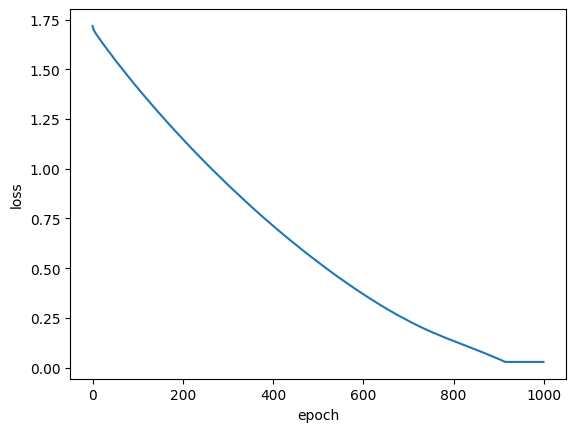

In [16]:
plt.plot(range(epochs),train_loss)
#print(train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")

In [17]:
net.load_state_dict(torch.load("../model_param/FFTCNN_model_for_NEE_XAI_test2.pth",map_location=device))#pytoch 导入模型

<All keys matched successfully>

In [18]:
# net.load_state_dict(torch.load("model1.pth",map_location=device))#pytoch 导入模型
test_dataset = torch.from_numpy(test_dataset).to(dtype=torch.float32)
test_dataset = test_dataset.to(device=device)
net.eval()#这里指评价模型，不反传，所以用eval模式
pre_y = net(test_dataset[:,:,1:])
pre_y = pre_y.detach().cpu().numpy()#输出结果torch tensor，需要转化为numpy类型来进行可视化
print(pre_y.shape)
test_dataset = test_dataset.cpu().numpy()
x = test_dataset[:,time_window-1,0].squeeze() 
y = pre_y.squeeze()

(379, 1)


0.5373174548149109


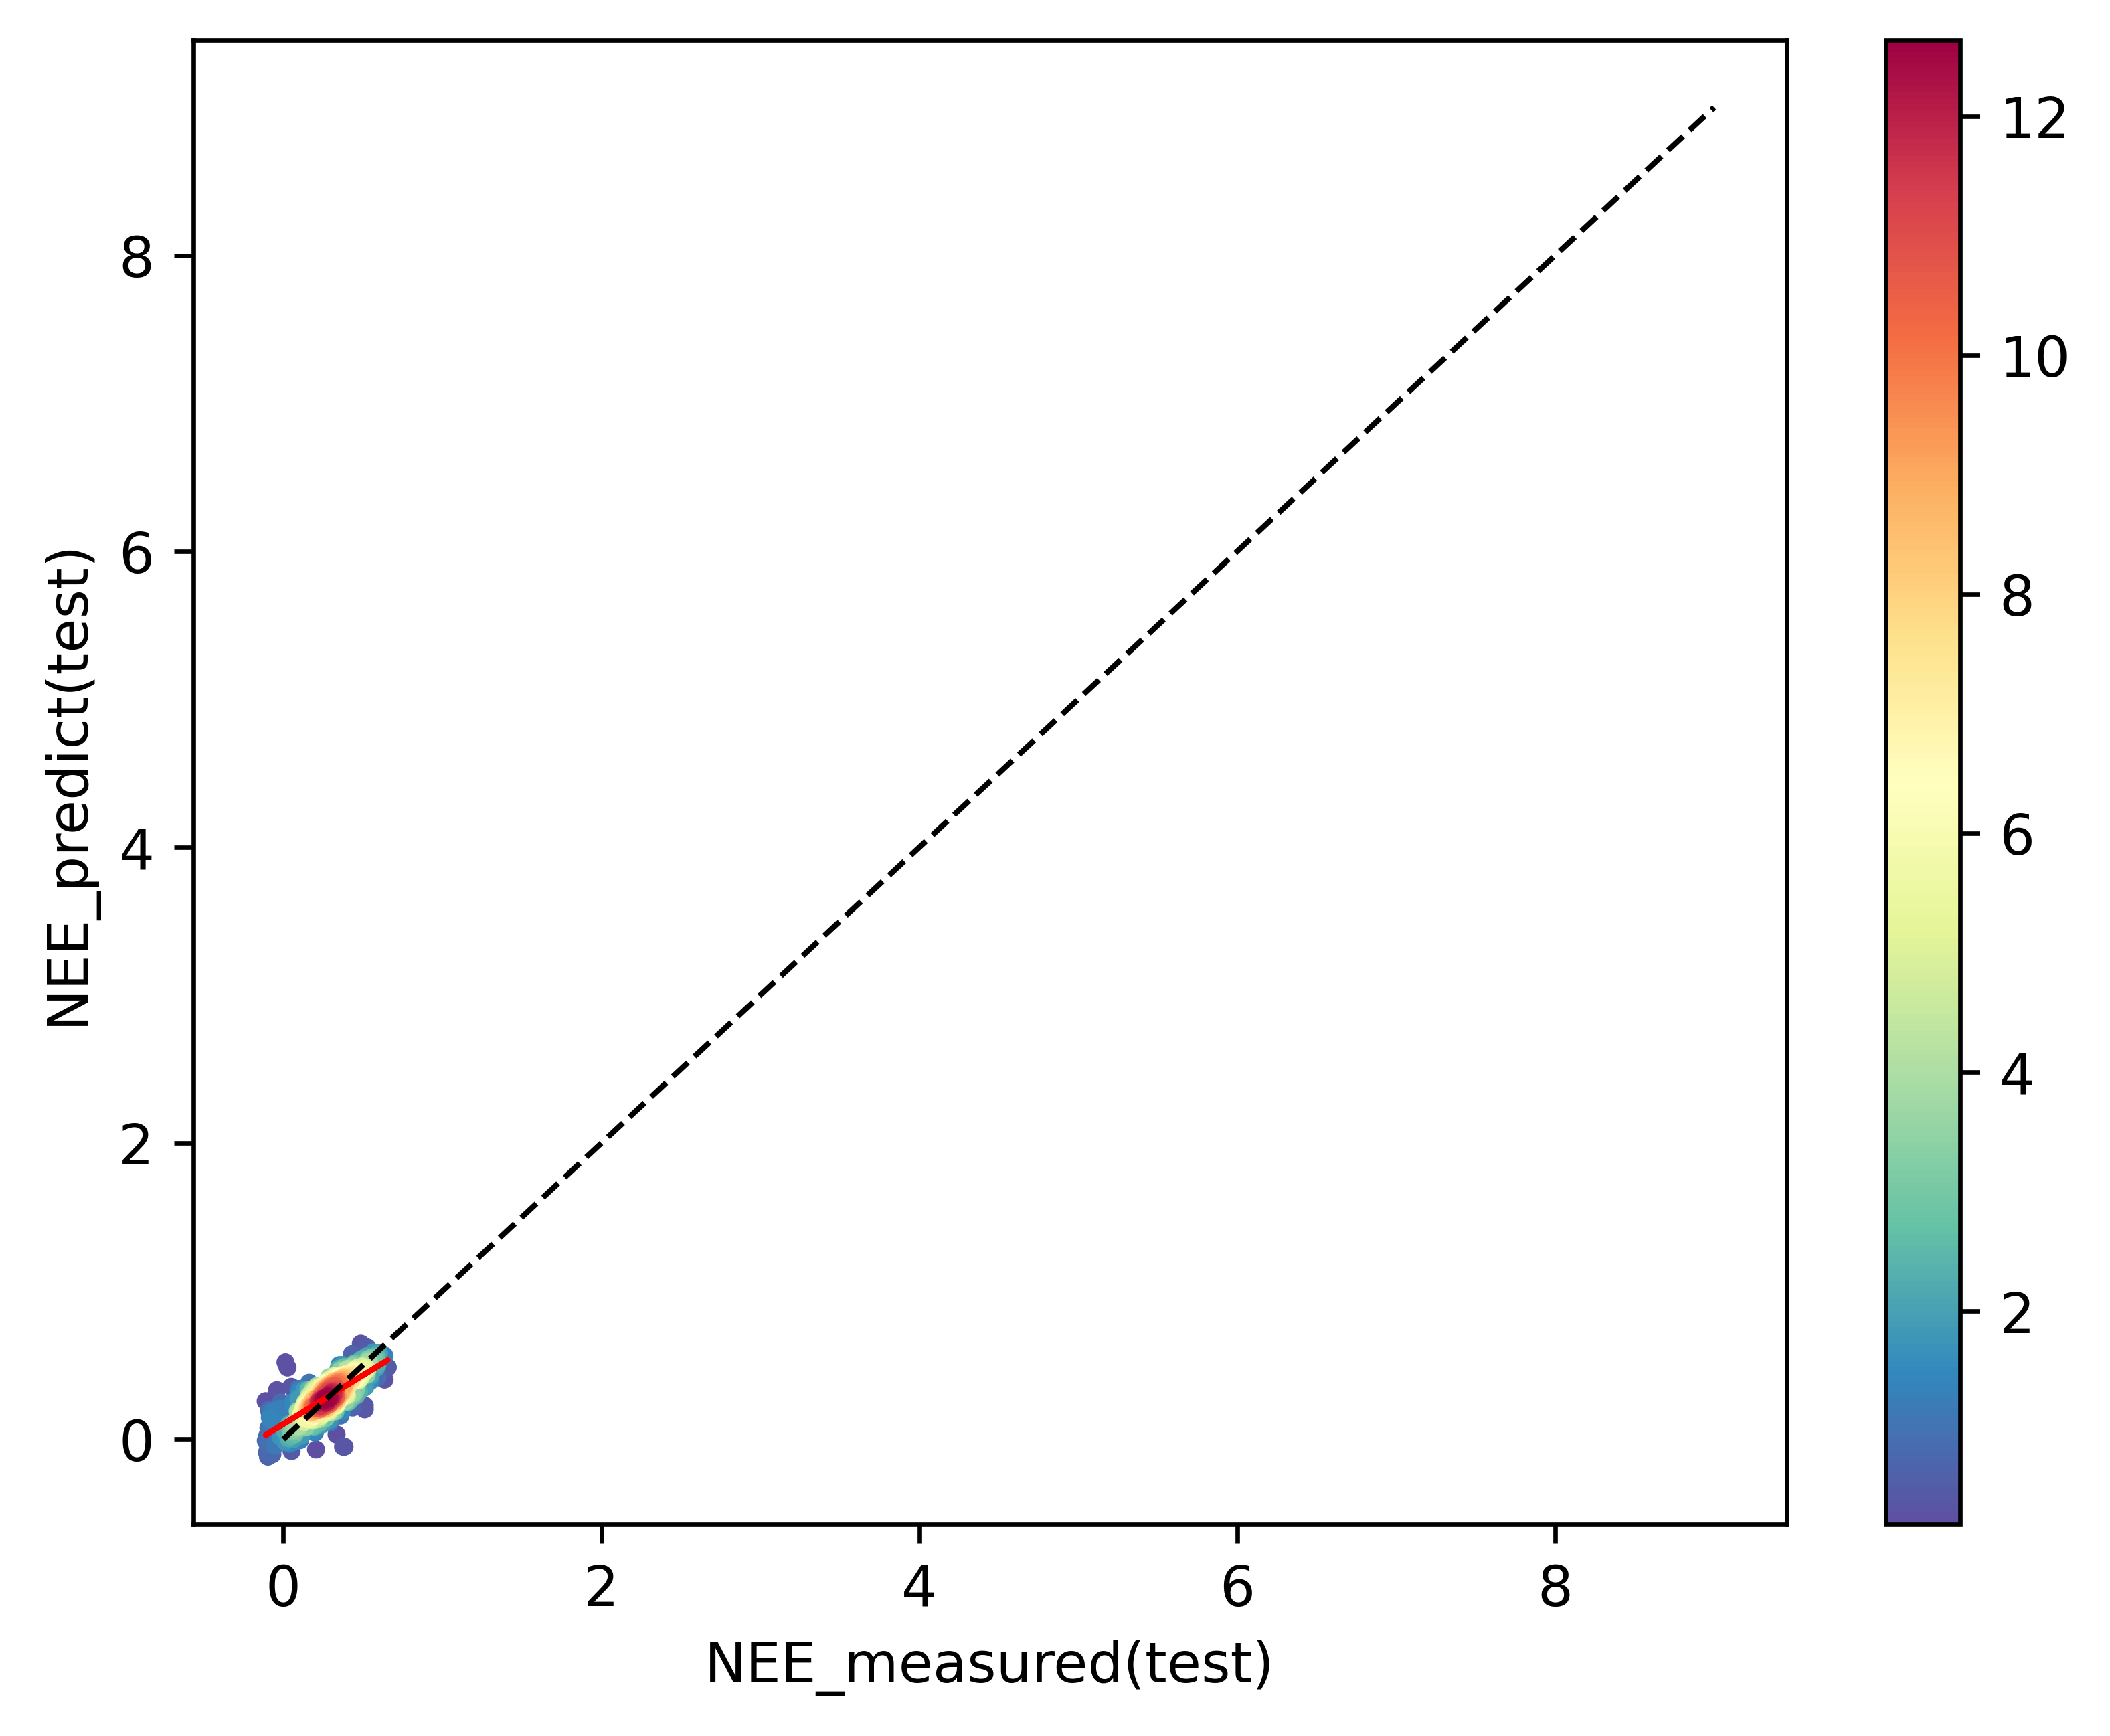

In [19]:
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error,explained_variance_score
from tqdm import tqdm
from timm.layers import trunc_normal_
xy = np.vstack([x,y])  #  将两个维度的数据叠加
z = gaussian_kde(xy)(xy)  # 建立概率密度分布，并计算每个样本点的概率密度

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots(dpi=600)
plt.scatter(x, y,c=z, s=5,cmap='Spectral_r') # c表示标记的颜色
plt.colorbar()

z = np.polyfit(x, y, 1) 
p = np.poly1d(z) 

plt.plot(x,p(x),markerfacecolor='r',linewidth=1,color='red')

std_x = np.arange(10)
std_y = std_x

plt.xlabel("NEE_measured(test)")
plt.ylabel("NEE_predict(test)")
plt.plot(std_x,std_y,linestyle='--',linewidth=1,color='black')
r2=r2_score(x,y)
print(r2)

In [20]:
rmse=np.sqrt(mean_squared_error(x,y))
print(rmse)

0.10922686729500494


In [21]:
mae=mean_absolute_error(x,y)
print(mae)

0.07757432013750076


In [22]:
y_test=x
y_pred=y

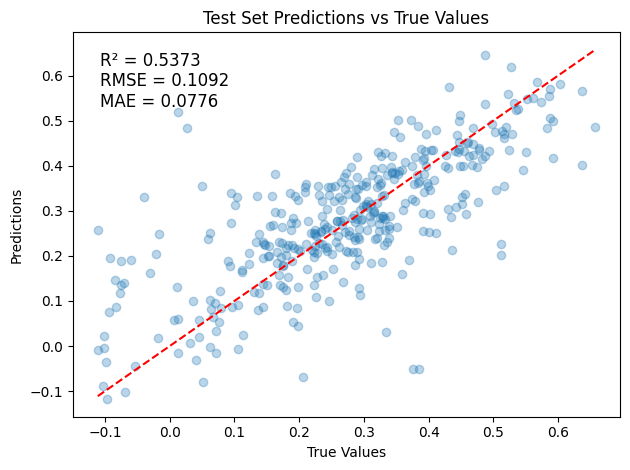

In [23]:
#plt.figure(figsize=(12, 5))

#plt.subplot(1,2, 1)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.text(0.05, 0.95, f'R² = {r2:.4f}\nRMSE = {rmse:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Test Set Predictions vs True Values')
#plt.text(0.05, 0.95, f'R² = {0.7280:.4f}\nRMSE = {44.3021:.4f}\nMAE = {26.1644:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
#plt.savefig(r"D:\毕业论文\新结结果\V2-ALL.jpg",dpi=300)
#plt.savefig("../pic/LSTM-result1.jpg",dpi=300)
#plt.savefig(r"D:\毕业论文\最新论文图\Smask\森林.jpg",dpi=300)
plt.tight_layout()
plt.show()

In [24]:
# 解释性分析函数
def interpret_saliency(model, sample):
    model.eval()
    with torch.no_grad():
        # 获取显著性掩码
        saliency_map = model.saliency_module(sample.unsqueeze(0), training=False)
        return saliency_map.squeeze().cpu().numpy()

# 可视化示例
def visualize_saliency(sample, saliency_map, time_steps=None, feature_names=['Ta', 'Ma', 'Rd', 'Rn', 'PAR', 'Tsoil', 'P', 'NDVI', 'EVI', 'Fpar']):
    # 原始数据
    plt.subplot(2, 1, 1)
    plt.imshow(sample.cpu().numpy().T, aspect='auto')#.T转置
    plt.title("Original Features")
    """
    saliency_map: 形状为 (时间步数, 特征数) 的矩阵
    """
    plt.figure(figsize=(10, 6))
    
    # 调整坐标轴方向
    plt.imshow(saliency_map.T, 
               aspect='auto', 
               cmap='viridis',
               origin='lower',  # 关键修改：y轴原点在左下
               extent=[0, saliency_map.shape[0], 0, saliency_map.shape[1]])  # [xmin, xmax, ymin, ymax]
    
    # 坐标轴标注
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Feature Index", fontsize=12)
    plt.title("Saliency Map (Time vs Feature)", pad=20)
    
    # 自定义刻度（示例）
    if time_steps is not None:
        plt.xticks(np.arange(saliency_map.shape[0]), 
                   labels=time_steps,
                   rotation=45)
    if feature_names is not None:
        plt.yticks(np.arange(saliency_map.shape[1]), 
                   labels=feature_names)
    
    # 添加颜色条
    cbar = plt.colorbar()
    cbar.set_label("Importance Score", rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

#def visualize_saliency(sample, saliency_map):
#    plt.figure(figsize=(12, 6))
    
    # 原始数据
#    plt.subplot(2, 1, 1)
#    plt.imshow(sample.cpu().numpy().T, aspect='auto')#.T转置
#    plt.title("Original Features")
    
    # 显著性图
#    plt.subplot(2, 1, 2)
#    plt.imshow(saliency_map.T, aspect='auto', cmap='viridis')
#    plt.title("Saliency Map")
#    plt.colorbar()
    
#    plt.tight_layout()
#    plt.show()

In [25]:
test_X = test_dataset[:, :, 1:]
test_Y = test_dataset[:, time_window - 1, 0]
test_X = torch.from_numpy(test_X).to(device=device, dtype=torch.float32)
test_Y = torch.from_numpy(test_Y).to(device=device, dtype=torch.float32)

In [26]:
# 解释性分析
#test_sample = test_dataset[0][:, 1:].  # 取第一个测试样本
test_sample = test_X[155] # 取第一个测试样本
saliency = interpret_saliency(net, test_sample)
visualize_saliency(test_sample, saliency)

TypeError: forward() got an unexpected keyword argument 'training'

In [ ]:
# 评估阶段，计算特征重要性


test_set = TensorDataset(test_X, test_Y.view(-1, 1))
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

# 计算特征重要性
feature_importance = []
with torch.no_grad():
    for test_x, test_y in test_loader:
        test_x_hat = generate_reference_x(test_x)
        pred_y = net(test_x)
        importance = net.saliency_module.mask.cpu().numpy()
        feature_importance.append(importance)
feature_importance = np.mean(feature_importance, axis=0).squeeze()
print(feature_importance)
# 绘制特征重要性图
plt.figure(figsize=(10, 6))
plt.imshow(feature_importance, cmap='viridis', aspect='auto')
plt.colorbar(label='Feature Importance')
plt.xlabel('Time Step')
plt.ylabel('Feature Index')
plt.title('Feature Importance Map')
plt.show()

In [ ]:
def saliency_map(model, input_data):
    input_data.requires_grad = True
    output = model(input_data)
    
    # 对输出进行反向传播
    model.zero_grad()
    output.backward(torch.ones_like(output))
    
    # 获取输入的梯度
    saliency = input_data.grad.abs().cpu().data.numpy()

    # 假设 saliency 的形状是 (batch_size, time_step, channel)
    # 选择所有批次和所有时间步的第一个通道
    saliency_first_channel = saliency[:, :, 0]

    # 对所有批次的显著性图在每个时间步上求平均
    mean_saliency = np.mean(saliency_first_channel, axis=0)  # 对第一维 (batch_size) 求平均

    # 绘制平均显著性图
    plt.plot(mean_saliency)  # 横坐标是时间步，纵坐标是所有批次在该时间步的平均显著性值
    plt.title("Time-Series Saliency Map (Averaged over all batches, first channel)")
    plt.xlabel("Time step")
    plt.ylabel("Average Saliency")
    plt.show()
    
    # 可视化显著性图
    #plt.plot(saliency[:, :, 0])  # 只显示第一个通道的显著性图
    #plt.title("Time-Series Saliency Map")
    #plt.show()

# 生成显著性图
saliency_map(net,test_X)
